## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

import torchtext
from torchtext.data import get_tokenizer   # for tokenization
from collections import Counter     # for tokenizer

import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
# import matplotlib.image as Image
import PIL
from PIL import Image

# for the bleu scores
import nltk
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
#nltk.download('all')

## Data Preprocessing

In [4]:
captions_path = "./train.csv"
images_path = "./train/"

### Read the Captions

In [5]:
# READ THE CAPTIONS FILE.txt
df = pd.read_csv(captions_path)

print(f"No of captions: {len(df)}")
df.head()

No of captions: 74565


,img_name,img_path,mos,comments
0,41wy7upxzl,./train/41wy7upxzl.jpg,5.569231,"the pink and blue really compliment each other. like the dense color, blur."
1,ygujjq6xxt,./train/ygujjq6xxt.jpg,6.103175,love rhubarb! great colors!
2,wk321130q0,./train/wk321130q0.jpg,5.541985,i enjoy the textures and grungy feel to this. i also really like the deep rich red color.
3,w50dp2zjpg,./train/w50dp2zjpg.jpg,6.234848,"i like all the different colours in this pic, the brown, green, dark grey, light grey, cool image."
4,l7rqfxeuh0,./train/l7rqfxeuh0.jpg,5.190476,"i love these critters, just wish he was a little sharper, nice comp though."


### Descriptor mapping

In [6]:
class my_dictionary(dict): 
  
    # __init__ function 
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value 
    def add(self, key, value): 
        if key not in self.keys():
            self[key] = [value]
        else:
            self[key].append(value)
        
descriptors = my_dictionary() 

In [7]:
for i in range(len(df)):
    img_id = df.iloc[i, 0] + ".jpg"
    sentence = ("<start> " + df.iloc[i, 3] + " <end>").split()
    
    descriptors.add(img_id, sentence)

In [8]:
print(descriptors['000u6xf6ah.jpg'])

[['<start>', 'colors', 'are', 'missing', 'the', 'natural', 'feeling', 'and', 'are', 'a', 'bit', 'flat', '<end>']]


### Check any Image

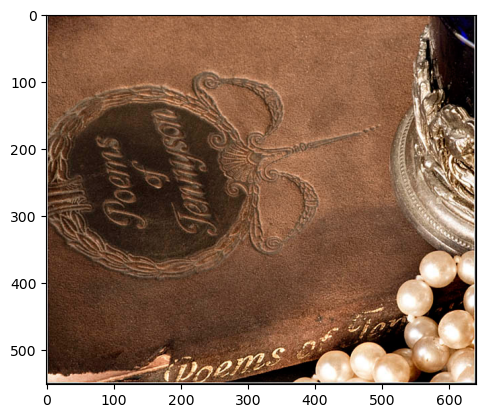

love the idea. the books texture is a bit flat though.


In [9]:
# get image path
image_indx = 20
image_path = images_path + df.iloc[image_indx, 0] + ".jpg"

# read the image
img = Image.open(image_path)
plt.imshow(img)
plt.show()

# print the captions related to this image
for i in range(image_indx, image_indx+1):
    print(df.iloc[i, 3])

## Data Processing

In [10]:
# TOKENIZER
tokenizer = get_tokenizer("basic_english")

# TOKEN COUNTER
token_counter = Counter()

### Text Data

In [23]:
class textVocab:
    # method to initialize the variables
    def __init__(self):
        # MAIN DICT
        # create dict (int to word) (like token counter)
        self.itos = {0:"<PAD>", 1:"<start>", 2:"<end>", 3:"<UNK>"}
        
        # create dict (word to int) 
        self.stoi = {b:a for a, b in self.itos.items()}   
        
        # initialize word freq threshold
        self.min_freq = 1
        
        # MAIN COMPONENTS
        # tokenizer
        self.tokenizer = get_tokenizer("basic_english")

        # token counter
        self.token_counter = Counter()
        
    # method to get size of vocabulary
    def __len__(self):
        return len(self.itos)
    
    # method to tokenize sentence
    def tokenize(self, text):
        return self.tokenizer(text)
    
    # method to numericalize sentence
    def numericalize(self, text):
        
        # tokenize the sentence
        tokens_list = self.tokenize(text)
        
        ans = []
        # convert words into ints (using stoi)
        for token in tokens_list:
            if token in self.stoi.keys():
                ans.append(self.stoi[token]) 
            else:
                ans.append(self.stoi["<UNK>"])
        return ans
#         return [ self.stoi[token] if token in self.stoi.keys() else self.stoi["<UNK>"] for token in tokens_list]
    
    # method to add new sentences to dict
    def build_vocab(self, sentence_list):
        word_count = 4
        
        # for each sentence
        for sentence in sentence_list:
            
            # tokenize
            tokens = self.tokenizer(sentence)
            
            # numericalize
            token_counter.update(tokens)
            
            # add words to vocab whose freq is >= min freq
            for token in tokens:
                if token_counter[token] >= self.min_freq and token not in self.stoi.keys():
                    self.stoi[token] = word_count
                    self.itos[word_count] = token
                    word_count += 1

### Image Data

In [24]:
weights = models.Inception_V3_Weights.DEFAULT
inception = models.inception_v3(weights=weights)
i = 0
for name, param in inception.named_parameters():  # named_parameters 가중치 뽑아주는 함수
    
    print(i,name)
    i+= 1
print(weights.transforms())

0 Conv2d_1a_3x3.conv.weight
1 Conv2d_1a_3x3.bn.weight
2 Conv2d_1a_3x3.bn.bias
3 Conv2d_2a_3x3.conv.weight
4 Conv2d_2a_3x3.bn.weight
5 Conv2d_2a_3x3.bn.bias
6 Conv2d_2b_3x3.conv.weight
7 Conv2d_2b_3x3.bn.weight
8 Conv2d_2b_3x3.bn.bias
9 Conv2d_3b_1x1.conv.weight
10 Conv2d_3b_1x1.bn.weight
11 Conv2d_3b_1x1.bn.bias
12 Conv2d_4a_3x3.conv.weight
13 Conv2d_4a_3x3.bn.weight
14 Conv2d_4a_3x3.bn.bias
15 Mixed_5b.branch1x1.conv.weight
16 Mixed_5b.branch1x1.bn.weight
17 Mixed_5b.branch1x1.bn.bias
18 Mixed_5b.branch5x5_1.conv.weight
19 Mixed_5b.branch5x5_1.bn.weight
20 Mixed_5b.branch5x5_1.bn.bias
21 Mixed_5b.branch5x5_2.conv.weight
22 Mixed_5b.branch5x5_2.bn.weight
23 Mixed_5b.branch5x5_2.bn.bias
24 Mixed_5b.branch3x3dbl_1.conv.weight
25 Mixed_5b.branch3x3dbl_1.bn.weight
26 Mixed_5b.branch3x3dbl_1.bn.bias
27 Mixed_5b.branch3x3dbl_2.conv.weight
28 Mixed_5b.branch3x3dbl_2.bn.weight
29 Mixed_5b.branch3x3dbl_2.bn.bias
30 Mixed_5b.branch3x3dbl_3.conv.weight
31 Mixed_5b.branch3x3dbl_3.bn.weight
32 Mixe

In [25]:
class MyInceptionFeatureExtractor(nn.Module):
    def __init__(self, inception, transform_input=False):
        super(MyInceptionFeatureExtractor, self).__init__()
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_2b_3x3
        
        # extra layers has been added since the comment
        self.maxpool1 = inception.maxpool1
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.maxpool2 = inception.maxpool2
        
        self.Mixed_5b = inception.Mixed_5b
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d
        self.Mixed_6a = inception.Mixed_6a
        self.Mixed_6b = inception.Mixed_6b
        self.Mixed_6c = inception.Mixed_6c
        self.Mixed_6d = inception.Mixed_6d
        self.Mixed_6e = inception.Mixed_6e
        
        self.AuxLogits = inception.AuxLogits
        
        self.Mixed_7a = inception.Mixed_7a
        self.Mixed_7b = inception.Mixed_7b
        self.Mixed_7c = inception.Mixed_7c
        
        # stop where you want, copy paste from the model def

    def forward(self, x):
        
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = self.maxpool1(x)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = self.maxpool2(x)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 17 x 17 x 768
        x = self.Mixed_5c(x)
        # 17 x 17 x 768
        x = self.Mixed_5d(x)
        # 17 x 17 x 768
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        
        return x

In [26]:
# define the transforms
inception_Transform = T.Compose([
    T.Resize(342),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Datasets and DataLoaders

### Custom Datasets

In [27]:
class customDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        # get image ids and captions 
        self.img_ids = self.df["img_name"]
        self.sentences = self.df["comments"]
        # initialize vocabulary
        self.vocab = textVocab()
        
        # create vocabulary (using list of sentences)
        self.vocab.build_vocab(self.sentences.tolist())
        print(len(self.vocab))
        
    def __len__(self):
        return len(self.df)
    
    # method to return pair of input and output data
    def __getitem__(self, idx):
        
        # get the caption and image path
        sentence = self.sentences[idx]
        img_id = self.img_ids[idx] + '.jpg'
        img_path = os.path.join(self.image_dir, img_id)
        
        # open the image
        img = Image.open(img_path).convert("RGB")
        
        # apply transformation on image(resize)
        if self.transform is not None:
            img = self.transform(img)
            
        # numericalize the caption
        vec = []
        
        vec += [self.vocab.stoi["<start>"]]   # tagging
        vec += self.vocab.numericalize(sentence)  # numericalization
        vec += [self.vocab.stoi["<end>"]]     # tagging
        
        # return text vector and image tensor
#         return img_id, vec
        return img, torch.tensor(vec), img_id

In [28]:
transforms = inception_Transform

In [29]:
transforms

Compose(
    Resize(size=342, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(299, 299))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [30]:
# Create custom dataset object
dataset = customDataset(
    image_dir = images_path,
    captions_file = captions_path,
    transform = transforms
)

23756


In [33]:
with open('vocab.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(dataset.vocab, file)

### Divide dataset indices into 3 parts

In [34]:
validation_split = .8
test_split = .9
shuffle_dataset = True
random_seed= 42

In [35]:
dataset_size = len(dataset)
indices = list(range(dataset_size))

# find the split point
val_split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(test_split * dataset_size))
    
# get the indices
train_indices, val_indices, test_indices = indices[:val_split], indices[val_split:test_split], indices[test_split:]

# shuffle the dataset
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

### Check our dataset

In [36]:
# create utility function to print images
def show_image(img, title=None):
    
    # unnormalize
    img[0] *= 0.229
    img[1] *= 0.224
    img[2] *= 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)    # wait for plots

03hgnq4mgk.jpg


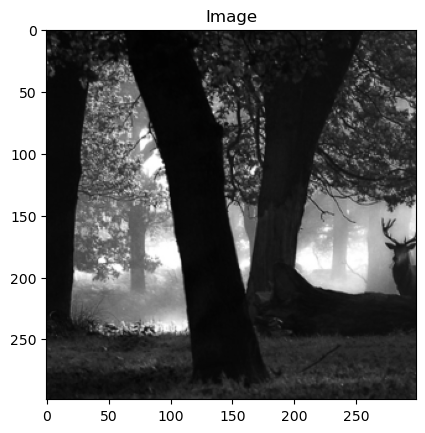

caption:  ['<start>', 'nice', 'capture', '.', 'the', 'light', 'quality', 'is', 'very', 'nice', '.', '<end>']


In [37]:
# get an item from dataset
img, vec, img_id = dataset[8083]
print(img_id)
show_image(img, "Image")

# need to convert returned vector into sentence
caption = [dataset.vocab.itos[token] for token in vec.tolist()]
print("caption: ", caption)

### DataLoaders

### Padding function

In [38]:
class Collate_fn:
    def __init__(self, pad_value, batch_first=False):
        self.pad_value = pad_value       # initialize padding value
        self.batch_first = batch_first    # col or row wise representation
        
    # this method is called for each batch in dataloader
    def __call__(self, batch):
        # get all inputs images
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)    # single tensor
        
        # get all captions
        captions = [item[1] for item in batch]
        
        # do padding on all text vectors   # single tensor
        captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)
        
        # get all image ids
        img_ids = [item[2] for item in batch]
        
        return imgs, captions, img_ids

### Create Dataloader

In [39]:
# define batch size
batch_size = 10

# initialize value to represent padding
pad_value = dataset.vocab.stoi["<PAD>"]

In [40]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [41]:
    train_loader = torch.utils.data.DataLoader(dataset, 
                                               batch_size=batch_size, shuffle=False,
                                               collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                    batch_size=batch_size,
                                                    collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                    sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                    batch_size=batch_size,
                                                    collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                    sampler=test_sampler)

### Check Dataloader

nice idea nice use of color


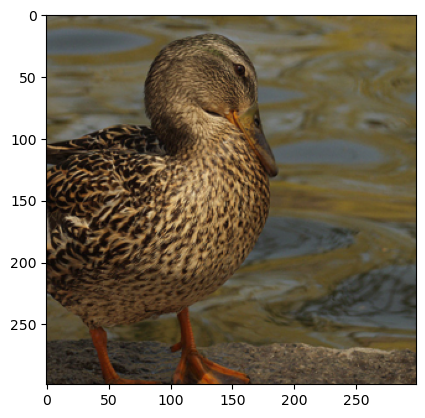

In [42]:
# dataloader iterator
trainItr = iter(train_loader)

# get a batch
batch = next(trainItr)

# get input and output values
imgs, captions, img_ids = batch

# show all items in it
for i in range(batch_size):
    img, caption = imgs[i], captions[i]
    
    # convert text vector into sentence
    sentence = [dataset.vocab.itos[token] for token in caption.tolist()]
    
    # get index of end token
    end_indx = sentence.index('<end>')
    
    # get from start to end and join
    sentence = sentence[1:end_indx]
    sentence = ' '.join(sentence)
    
    # also print image
    print(sentence)
    show_image(img)
    plt.show()
    
    break

## Model Implementaion

### Encoder Model

In [43]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.my_inception = MyInceptionFeatureExtractor(inception)
        
    def forward(self, images):
#         print(images.shape) = [bs, 3, 299, 299]
        
        # get the feature maps
        features = self.my_inception(images) 
#         print(features.shape) = [bs, 2048, 8, 8]
        
        features = features.permute(0, 2, 3, 1)
#         print(features.shape) = [bs, 8, 8, 2048]
        
        features = features.view(features.size(0), -1, features.size(-1))
#         print(features.shape) = [2, 64, 2048]
        
        return features

### Attention Model

In [44]:
class Attention(nn.Module):
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
    
        # initialize the shapes
        self.attention_dim = attention_dim
        
        # create linear layer's to transform following
        # (input shape, output shape)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # decoder's output
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # encoded image
        self.full_att = nn.Linear(attention_dim, 1)  # attention's output
    
    # input - features of image and hidden state value
    def forward(self, features, hidden_states):
        # pass the tensor's through linear layers
        att1 = self.encoder_att(features)   
        att2 = self.decoder_att(hidden_states)
        
#         print(att1.shape, att2.shape)   # torch.Size([32, 64, att_dim]) torch.Size([32, att_dim])
        
        # combine both attentions
        combined_states = torch.tanh(att1 + att2.unsqueeze(1))
        
#         print(combined_states.shape)      # torch.Size([32, 64, att_dim])

        # pass combined state through last linear layer
        attention_scores = self.full_att(combined_states)
        
#         print(attention_scores.shape)     # torch.Size([bs, 64, 1])
        attention_scores = attention_scores.squeeze(2)
#         print(attention_scores.shape)   # torch.Size([32, 64])
        

        # calculate alpha 
        alpha = F.softmax(attention_scores, dim=1)
        
        # get attention weights
        weighted_encoding = features * alpha.unsqueeze(2)   # torch.Size([bs, 64, 1])
        weighted_encoding = weighted_encoding.sum(dim=1)    # sum all weights at dim 1
        
        # return alpha and attention weights (both are tensors)
        return alpha, weighted_encoding

### Decoder Model

In [45]:
class Decoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()
        
        # initialize the model parameters
        self.vocab_sz = vocab_sz
        self.att_dim = att_dim
        self.dec_dim = dec_dim
        
        # initialize embedding model and attention model
        self.embedding = nn.Embedding(vocab_sz, embed_sz)
        self.attention = Attention(enc_dim, dec_dim, att_dim)
        
        # create the hidden and cell state
        self.init_h = nn.Linear(enc_dim, dec_dim)
        self.init_c = nn.Linear(enc_dim, dec_dim)
        
        # create lstm cell
        self.lstm_cell = nn.LSTMCell(embed_sz + enc_dim, dec_dim, bias=True)
        
        # create other nn layers
        self.f_beta = nn.Linear(dec_dim, enc_dim)
        self.fcn = nn.Linear(dec_dim, vocab_sz)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions, teacher):
        
        # vectorize the captions(tokenized):
        embeds = self.embedding(captions)
        # initialize hidden and cell state
        h, c = self.init_hidden_state(features)
        
        # get the captions length in current batch
        cap_len = len(captions[0]) - 1
        
        # get batch size and features size
        batch_sz = captions.size(0)
        num_features = features.size(1)
        
        # create tensor of zeros for predictions and alpha
        preds = torch.zeros(batch_sz, cap_len, self.vocab_sz).to(device)
        alphas = torch.zeros(batch_sz, cap_len, num_features).to(device)
        
        for i in range(cap_len):
            # get alpha and attention weights
            alpha, att_weights = self.attention(features, h)
            
            # use teacher forcing according teacher * 100%
            if i == 0 or np.random.rand() < teacher:
                lstm_input = torch.cat((embeds[:,i], att_weights), dim=1)
            else:
                # output 10,23756 -> argmax 10, 1 -> embed 10, 500
                output = [output[j, :].reshape(1, -1).argmax(dim=1).item() for j in range(batch_sz)]
                output = torch.tensor(np.array(output)).to(device)
                output = self.embedding(output)
                lstm_input = torch.cat((output, att_weights), dim=1)
            
            # pass through lstm cell
            h, c = self.lstm_cell(lstm_input, (h, c))

            # pass through linear layer
            output = self.fcn(self.drop(h))

            # store the output and alpha
            preds[:, i] = output
            alphas[:, i] = alpha
            
        return preds, alphas
    
    # create method to generate captions
    def generate_caption(self, features, max_len=40, vocab=None):
        batch_sz = features.size(0)
        
        # hidden and cell state
        h, c = self.init_hidden_state(features)
        
        alphas = []
        captions = [vocab.stoi['<start>']]
        
        # starting input
        word = torch.tensor(vocab.stoi['<start>']).view(1, -1).to(device)
        embeds = self.embedding(word)
        
        # get next 40 words
        for i in range(max_len):
            alpha, weighted_encoding = self.attention(features, h)
            
            # store alpha score
            alphas.append(alpha.cpu().detach().numpy())
            
            # update hidden and cell state
            lstm_input = torch.cat((embeds[:, 0], weighted_encoding), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
    
            # pass through layers
            output = self.fcn(self.drop(h))
            output = output.view(batch_sz, -1)
            
            # select the best word
            pred_word_idx = output.argmax(dim=1)
            
            # save the word
            captions.append(pred_word_idx.item())
        
            # stop when end of sentence
            if vocab.itos[pred_word_idx.item()] == '<end>':
                break
                
            # next input
            embeds = self.embedding(pred_word_idx.unsqueeze(0))
            
        # return sentence
        return [vocab.itos[idx] for idx in captions], alphas  # if idx != 0 and idx != 1 and idx != 2
    
    # method to get hidden and cell state value
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        
        # return hidden and cell state
        return h, c

### Encoder-Decoder Model

In [46]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()
        
        # crete the encoder and decoder models
        self.encoder = Encoder()
        
        # encoder freezing
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.decoder = Decoder(
            embed_sz = embed_sz,
            vocab_sz = vocab_sz,
            att_dim = att_dim,
            enc_dim = enc_dim,
            dec_dim = dec_dim
        )
    
    def forward(self, images, captions, teacher):
        # extract image features
        features = self.encoder(images)
        
        # generate captions
        outputs = self.decoder(features, captions, teacher)

        # return predicted caption, attention alphas
        return outputs

## Hyperparameters

In [47]:
embed_sz = 300
vocab_sz = len(dataset.vocab)
att_dim = 256
enc_dim = 2048
dec_dim = 512
learning_rate = 0.00005

## Model

In [49]:
# initialize model
model = EncoderDecoder(
    embed_sz = 300,
    vocab_sz = len(dataset.vocab),
    att_dim = 128,
    enc_dim = 2048,
    dec_dim = 256
).to(device)

In [50]:
# create criterion and optimizer for weights
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=False)

## Training

In [51]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [52]:
print_each = 100
epochs = 30

C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


<Figure size 640x480 with 0 Axes>

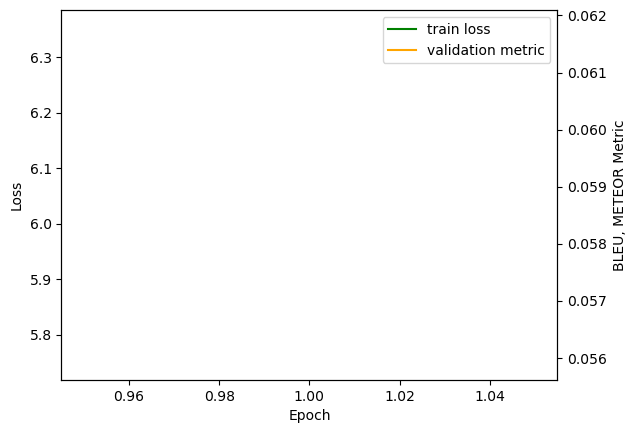

1 epochs : train_loss = 6.051587313303707, validation metric = 0.05885580937378883
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

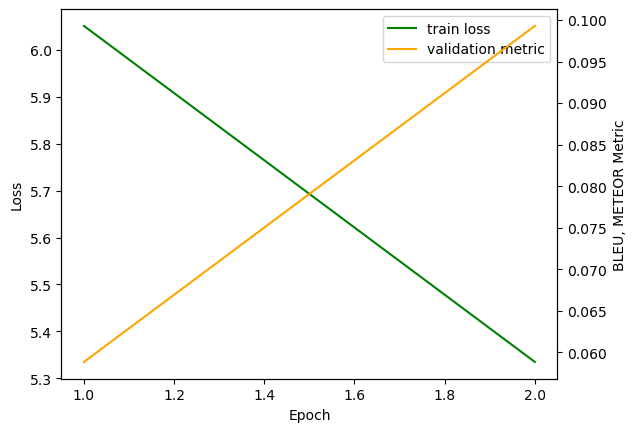

2 epochs : train_loss = 5.334579207436272, validation metric = 0.09928506425355837
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

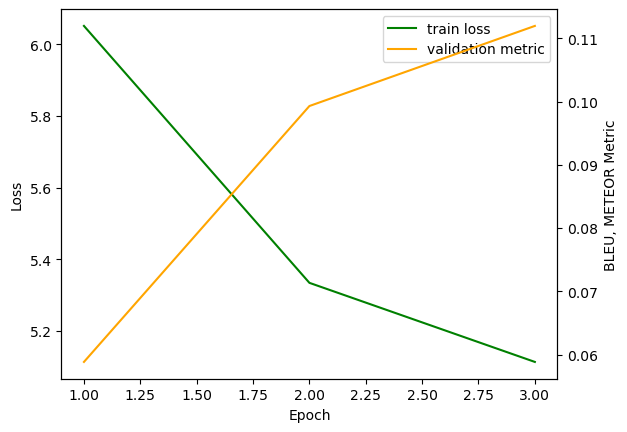

3 epochs : train_loss = 5.113864420709384, validation metric = 0.11194118787182605
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

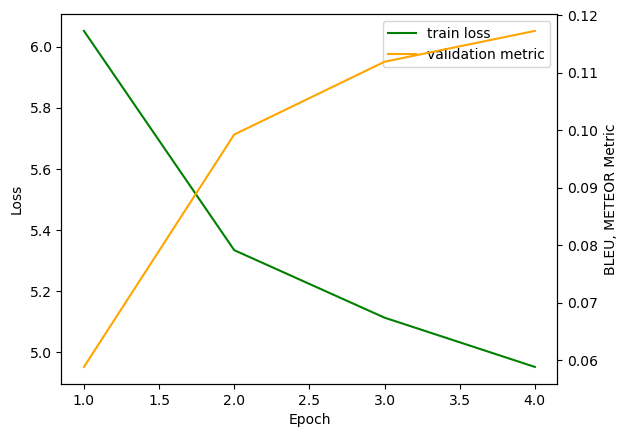

4 epochs : train_loss = 4.952814254787601, validation metric = 0.11730076586392457
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

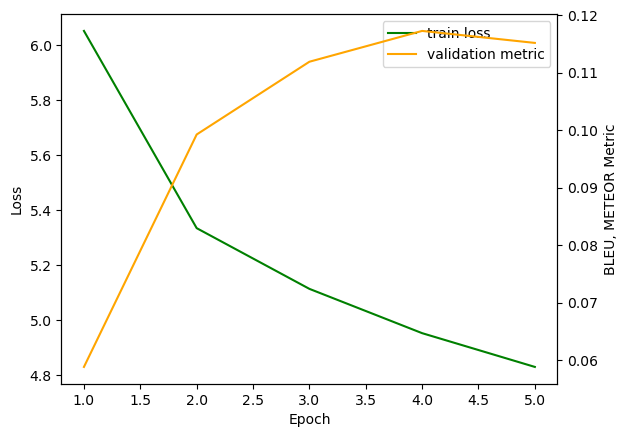

5 epochs : train_loss = 4.8300915021240245, validation metric = 0.11521557402056398
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

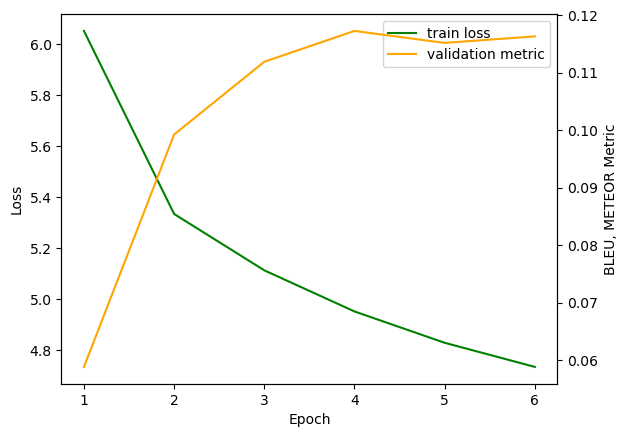

6 epochs : train_loss = 4.735542282103405, validation metric = 0.11635602293736086
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

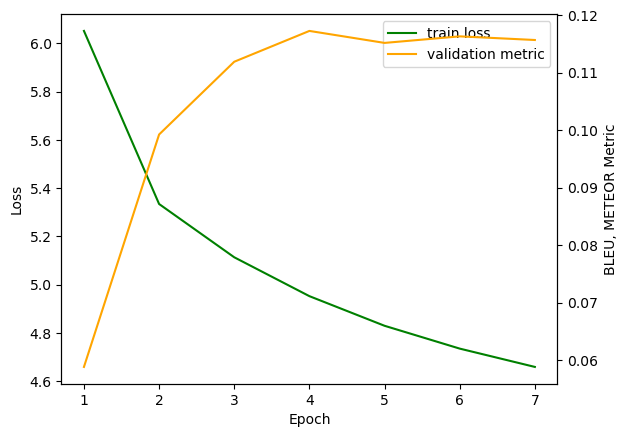

7 epochs : train_loss = 4.659662060851759, validation metric = 0.11572271186670358
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

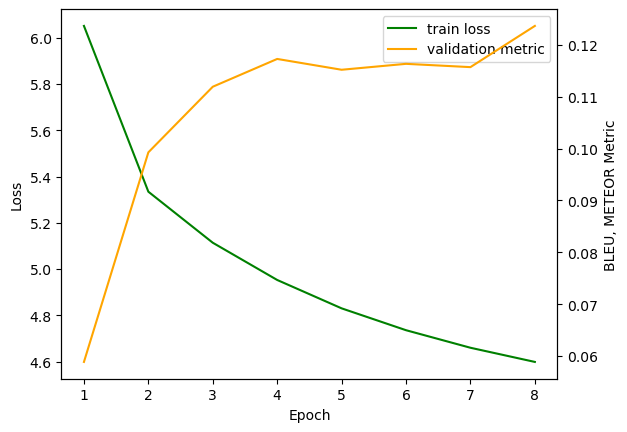

8 epochs : train_loss = 4.598383929922428, validation metric = 0.1236710798643467
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

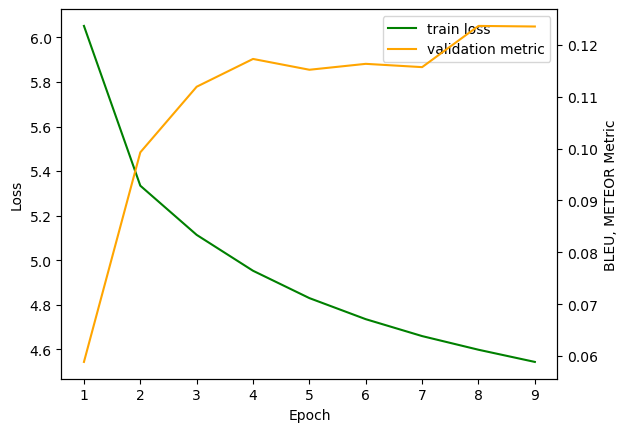

9 epochs : train_loss = 4.543745755062155, validation metric = 0.12355857184522129
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

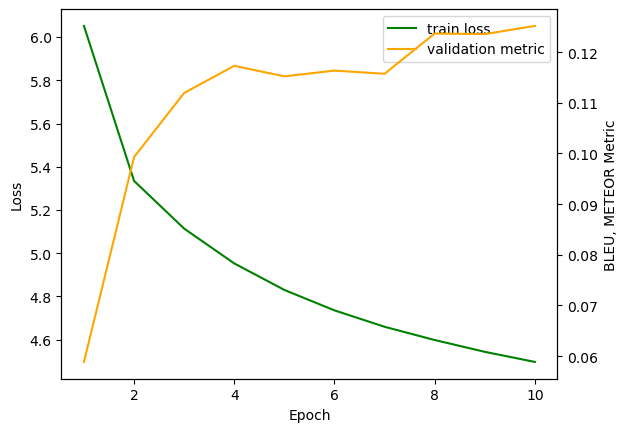

10 epochs : train_loss = 4.497042709350394, validation metric = 0.1251715061853003
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

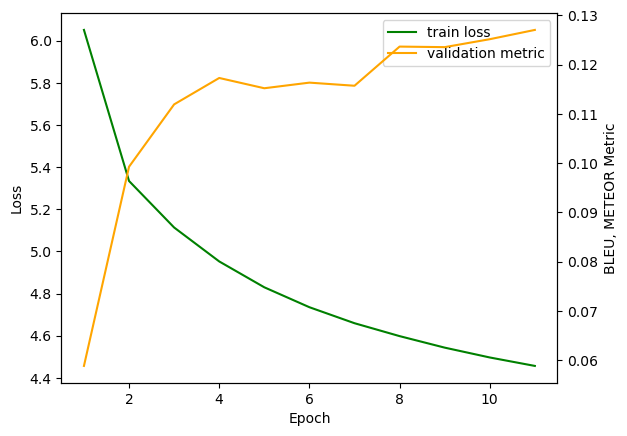

11 epochs : train_loss = 4.4569343412009585, validation metric = 0.12705420223523184
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

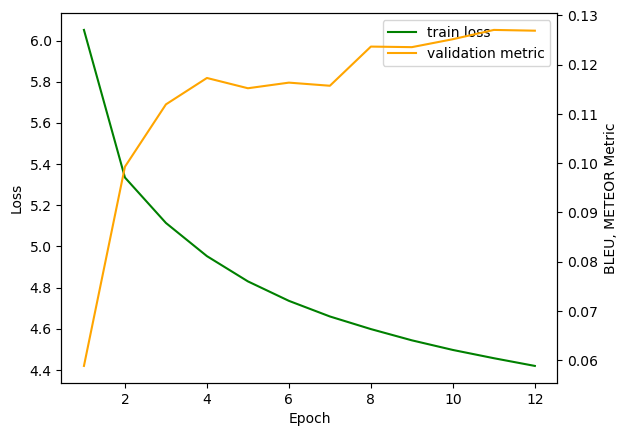

12 epochs : train_loss = 4.41947552137497, validation metric = 0.12689788386743686
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

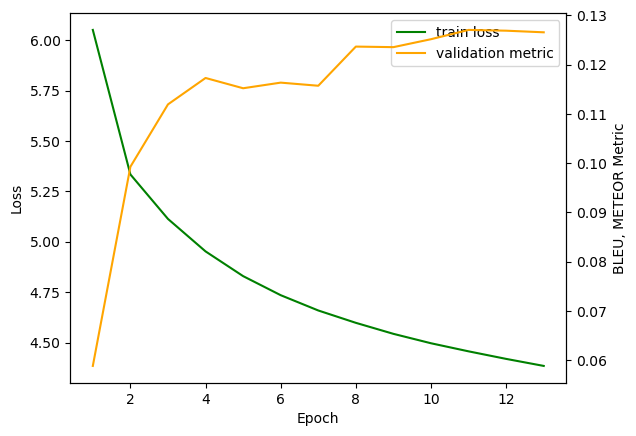

13 epochs : train_loss = 4.384613869967678, validation metric = 0.12656990771648324
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

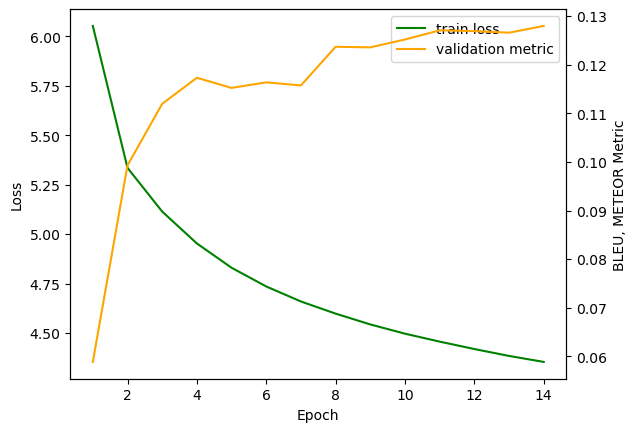

14 epochs : train_loss = 4.354396624231949, validation metric = 0.1279636045600428
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

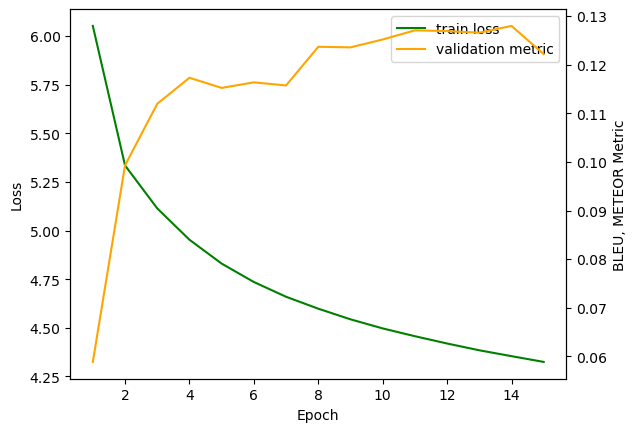

15 epochs : train_loss = 4.324834859883579, validation metric = 0.12215251449024839
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

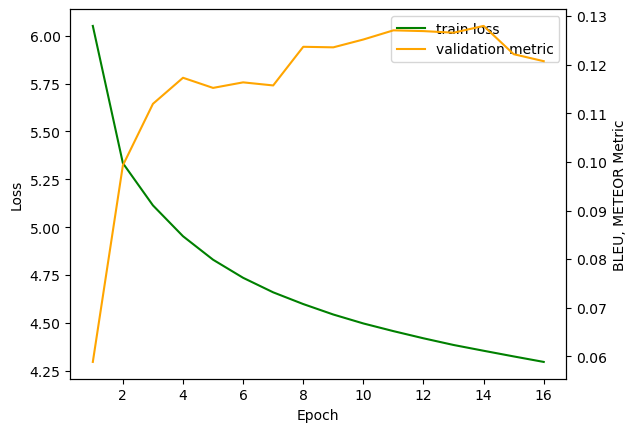

16 epochs : train_loss = 4.296063279822616, validation metric = 0.12071041602843019
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

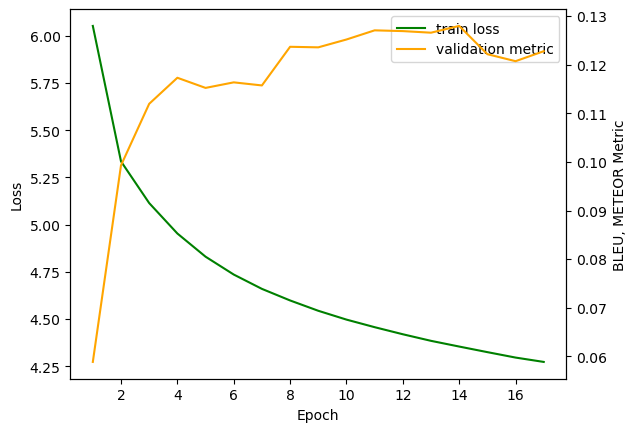

17 epochs : train_loss = 4.273029305737783, validation metric = 0.12276188738618737
current learning rate : 1e-05


<Figure size 640x480 with 0 Axes>

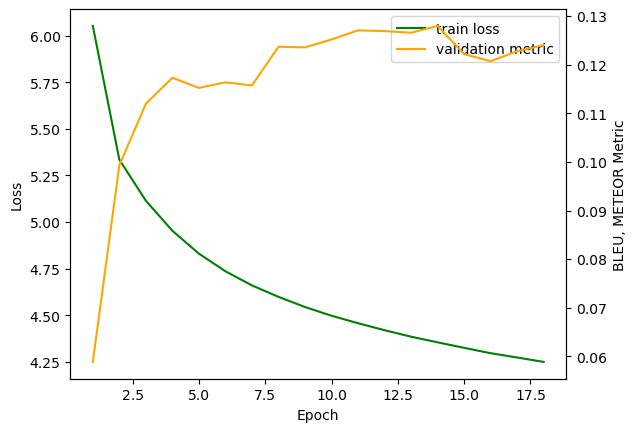

18 epochs : train_loss = 4.249368073642434, validation metric = 0.12403029232051381
current learning rate : 1e-05


In [ ]:
train_loss = []
val_metric = []
highest_val = 0
for epoch in range(1, epochs+1):
    model.train()
    train_loss.append(0)
    val_metric.append(0)
    for idx, (img, captions, img_ids) in enumerate(iter(train_loader)):
        # store the device (same-same)
        img, captions = img.to(device), captions.to(device)
        targets = captions[:, 1:]
        
        # make gradients zero
        optimizer.zero_grad()
        
        # pass through encoder-decoder model 
        pred_caps, attentions = model(img, captions, teacher=max(0, 1 - 0 * epoch))
        
        # calculate batch loss
        loss = criterion(pred_caps.view(-1, vocab_sz), targets.reshape(-1))
        train_loss[-1] += loss.item() * train_loader.batch_size
        
        # backward pass
        loss.backward()    # update the NN weights
        
        # update the weights in optimizer
        optimizer.step()
    
    # Validaion calculate
    model.eval()
    y, yhat = list(), list()
    meteor = 0
    # iterate all batches
    for idxx, (img, captions, img_ids) in enumerate(iter(val_loader)):
        with torch.no_grad():
            for i in range(batch_size):
                if len(captions[i:i+1]) == 0:
                    break
                caption = captions[i:i+1][0].tolist()
                s = [dataset.vocab.itos[idx] for idx in caption if idx != 0]
                y.append(descriptors[img_ids[i]])
                features = model.encoder(img[i:i+1].to(device))
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
                yhat.append(pred_caps)
                meteor += meteor_score(descriptors[img_ids[i]], pred_caps)
    bleu_3 = corpus_bleu(y, yhat, weights=(0.3, 0.3, 0.3, 0))
    bleu_4 = corpus_bleu(y, yhat, weights=(0.25, 0.25, 0.25, 0.25))
    meteor = meteor / len(val_sampler)
    
    train_loss[-1] = train_loss[-1] / len(train_sampler)
    val_metric[-1] = (bleu_3 * 0.5 + bleu_4 * 0.5)/2 + meteor/2
    #scheduler.step(val_metric[-1])
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    line1 = ax1.plot(list(range(1, epoch+1)), train_loss, color = 'green', label='train loss')
    ax2 = ax1.twinx()
    ax2.set_ylabel('BLEU, METEOR Metric')
    line2 = ax2.plot(list(range(1, epoch+1)), val_metric, color = 'orange', label='validation metric')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    #plt.legend()
    plt.show()
    print(str(epoch) + " epochs : train_loss = " + str(train_loss[-1]) + ", validation metric = " + str(val_metric[-1]))
    print("current learning rate : " + str(optimizer.param_groups[0]['lr']))
    
    # save latest model
    #if highest_val < val_metric[-1]:
    PATH = './weights/IQA_no7_' + str(epoch) + 'epochs.pt'
    torch.save(model.state_dict(), PATH)
    #highest_val = val_metric[-1]

In [ ]:
PATH = './weights/IQA_no3_11epochs.pt'
torch.save(model.state_dict(), PATH)

## Model Testing

### Make Prediction

In [ ]:
PATH = './weights/IQA_no5_13epochs.pt'

In [ ]:
model.load_state_dict(torch.load(PATH))

In [ ]:
# # generate the captions for a whole batch
model.eval()
with torch.no_grad():
    # dls or validation_loader
    itr = iter(val_loader)
    img, captions, img_ids = next(itr)
    
    caption = captions[0:1][0].tolist()
    s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] # if idx != 0 and idx != 1 and idx != 2
    print("Original:", ' '.join(s))
    
    # extract features
    print(img[0:1].shape)
    features = model.encoder(img[0:1].to(device))

    # get predictions
    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    # make it printable
    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])

In [ ]:
def evaluateModel(model, dls):
    model.eval()
    
    # to store references and predictions
    y, yhat = list(), list()
    meteor = 0
    rouge = Rouge()
    
    # iterate all batches
    for idxx, (img, captions, img_ids) in enumerate(iter(dls)):
        print(idxx)
        with torch.no_grad():
            
            # iterate each record in batch
            for i in range(batch_size):
                
                # if empty record
                if len(captions[i:i+1]) == 0:
                    break
                
                # caption = captions[0:1][0].tolist()
                caption = captions[i:i+1][0].tolist()
                s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] #  and idx != 1 and idx != 2
                
                y.append(descriptors[img_ids[i]])

                # extract features
                features = model.encoder(img[i:i+1].to(device))

                # get predictions
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                yhat.append(pred_caps)
                #print(descriptors[img_ids[i]])
                #print(pred_caps)
                meteor += meteor_score(descriptors[img_ids[i]], pred_caps)
                # make it printable
                caption = ' '.join(pred_caps)
#                 print("Predicted ", caption)
#                 show_image(img[i])

#     y = [y]
#     print(y[0])
#     print(yhat[0])
    
    # calculate BLEU score
   
    print('BLEU-1: %f' % corpus_bleu(y, yhat, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(y, yhat, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(y, yhat, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(y, yhat, weights=(0.25, 0.25, 0.25, 0.25)))
    print('METEOR: %f' % (meteor / len(test_sampler)))

In [ ]:
evaluateModel(model, test_loader)

In [ ]:
submission_info_path = "./test.csv"
submission_output_path = "./submission2.csv"
submission_imgdir_path = "./test/"

In [ ]:
class submissionDataset(Dataset):
    def __init__(self, image_dir, info_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(info_file)
        self.transform = transform
        
        # get image ids
        self.img_ids = self.df["img_name"]
        
    def __len__(self):
        return len(self.df)
    
    # method to return pair of input and output data
    def __getitem__(self, idx):
        
        # get the caption and image path
        img_id = self.img_ids[idx] + '.jpg'
        img_path = os.path.join(self.image_dir, img_id)
        
        # open the image
        img = Image.open(img_path).convert("RGB")
        
        # apply transformation on image(resize)
        if self.transform is not None:
            img = self.transform(img)
            
        return img, img_id

In [ ]:
submission_dataset = customDataset(
    image_dir = submission_imgdir_path,
    captions_file = submission_info_path,
    transform = transforms
)

In [ ]:
submission_loader = DataLoader(submission_dataset, batch_size=1, suffle=False)

In [ ]:
model.eval()
with torch.no_grad():
    # dls or validation_loader
    itr = iter(submission_loader)
    img, img_id = next(itr)
    
    # extract features
    print(img[0:1].shape)
    features = model.encoder(img[0:1].to(device))

    # get predictions
    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    # make it printable
    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])